<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/image/IDSN-logo.png" width="200" alt="cognitiveclass.ai logo">


<h1>Linear  Classifier with PyTorch </h1>


<p>Before using deep neural network to solve the classification problem, we will try and solve the problem with the simplest method -- linear classifier. We will utilize the dataset object from the previous notebook.
After building and training linear classifier, we will determine linear classifier's maximum accuracy achieved on the validation data for 5 epochs. </p>

<h2>Table of Contents</h2>


1. Imports and Auxiliary Functions
2. Download Data
3. Dataset Class
4. Transform Object and Dataset Object
5. Question

<hr>

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import os
import glob

import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import skillsnetwork

<h2 id="download_data">Download Data</h2>


In this section, you are going to download the data from IBM object storage using **skillsnetwork.prepare** command. <b>skillsnetwork.prepare</b> is a command that's used to download a zip file, unzip it and store it in a specified directory. Locally we store the data in the directory  **/resources/data**. 


In [2]:
# Download the file that contains the images
await skillsnetwork.prepare("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip",
                            path = "/resources/data", overwrite = True)

  0%|          | 0/40000 [00:00<?, ?it/s]

Saved to '../../../data'


<h2 id="data_class">Dataset Class</h2>


In [3]:
# Dataset created in previous notebook

class Dataset(Dataset):

    # Constructor
    def __init__(self, transform = None, train = True):
        directory = "/resources/data"
        positive = 'Positive'
        negative= 'Negative'

        positive_file_path = os.path.join(directory, positive)
        negative_file_path = os.path.join(directory, negative)
        
        positive_files = [os.path.join(positive_file_path, file) for file
                          in os.listdir(positive_file_path) if file.endswith('.jpg')]
        positive_files.sort()
        
        negative_files = [os.path.join(negative_file_path, file) for file
                          in os.listdir(negative_file_path) if file.endswith('.jpg')]
        negative_files.sort()
        
        number_of_samples = len(positive_files) + len(negative_files)
        
        self.all_files = [None]*number_of_samples
        self.all_files[::2] = positive_files
        self.all_files[1::2] = negative_files
        
        # The transform will be used on image
        self.transform = transform
        
        # torch.LongTensor
        self.Y = torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2] = 1
        self.Y[1::2] = 0
        
        if train:
            self.all_files = self.all_files[0:30000] # Change to 10000 to decrease the training time
            self.Y = self.Y[0:30000] # Change to 10000 to decrease the training time
            self.len = len(self.all_files)
        else:
            self.all_files = self.all_files[30000:]
            self.Y = self.Y[30000:]
            self.len = len(self.all_files)
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        image = Image.open(self.all_files[idx])
        y = self.Y[idx]

        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

<h2 id="trasform_Data_object">Transform Object and Dataset Object</h2>


In [4]:
mean = [0.485, 0.456, 0.406] # Value for mean are provided
std = [0.229, 0.224, 0.225] # Value for std are provided

# Create transform object with Compose function -- transforms.Compose([])
# 1st use the transform ToTensor(), 2nd Normalize(mean, std)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

In [5]:
# Create object for the training data
training_dset = Dataset(transform = transform, train = True)

# Create object for the training data validation
validation_dset = Dataset(transform = transform, train = False)

In [6]:
# Find image shape
training_dset[0][0].shape

torch.Size([3, 227, 227])

In [7]:
# It is colored image with 3 channels (see output above); thus, calculation is multiplied by 3
size_of_image = 3*227*227
size_of_image

154587

<h2 id="Question"> Question </h2>


<b> Create a custom module for Softmax for two classes, called model.</b>


Train the model with the following free parameter values:


<b>Parameter Values</b>
   <li>learning rate:0.1 </li>
   <li>momentum term:0.1 </li>
   <li>batch size training:5</li>
   <li>Loss function:Cross Entropy Loss </li>
   <li>epochs:5</li>
   <li>set: torch.manual_seed(0)</li>


In [8]:
# Set seed so results can be replicated
torch.manual_seed(0)

In [9]:
# Define parameters
learning_rate = 0.1
momentum_term = 0.1
epochs = 5

In [10]:
# Create Custom Module

class SoftMax(nn.Module):
    def __init__(self, in_size, out_size):
        super(SoftMax, self).__init__()
        self.linear = nn.Linear(in_size, out_size)
    
    def forward(self, x):
        z = self.linear(x)
        return z

In [11]:
# Create Model Object

input_dim = size_of_image
output_dim = 2
model = SoftMax(input_dim, output_dim)

In [12]:
# Create Optimizer
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr = learning_rate, momentum = momentum_term)

# Define Criterion
criterion = nn.CrossEntropyLoss()

# Create Data Loader for Training and Validation datasets
train_loader = DataLoader(training_dset, batch_size = 5, shuffle = True)
validation_loader = DataLoader(validation_dset, batch_size = 500)

In [15]:
# Train Model (Takes long time!!!)

loss_list = []
accuracy_per_list = []
N_test = len(validation_dset)

def model_train(n_epochs):
    for epoch in range(n_epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x.view(-1, input_dim))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
        
        correct = 0
        for x_val, y_val in validation_loader:
            z = model(x_val.view(-1, input_dim))
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_val).sum().item()
        
        accuracy = (correct / N_test) * 100
        loss_list.append(loss)
        accuracy_per_list.append(accuracy)
model_train(epochs)

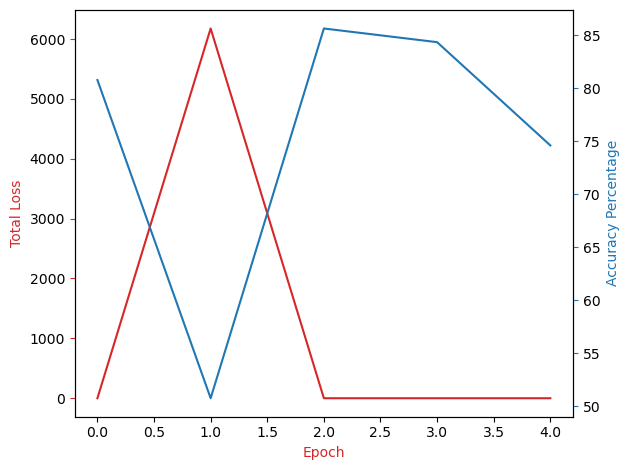

In [26]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color = color)
ax1.set_xlabel('Epoch',color = color)
ax1.set_ylabel('Total Loss',color = color)
ax1.tick_params(axis = 'y', color = color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Accuracy Percentage', color = color)  
ax2.plot(accuracy_per_list, color = color)
ax2.tick_params(axis = 'y', color = color)
fig.tight_layout()
plt.show()

Copyright &copy; 2019 <a href="cognitiveclass.ai"> cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>
